# Practical Time Series Analysis - CH02 R Code Snippets

## Cleaning Your Data

### Handling Missing Data

#### Preparing a data set to test missing data imputation methodologies

In [1]:
require(zoo);
require(data.table);

Le chargement a nécessité le package : zoo


Attachement du package : ‘zoo’


Les objets suivants sont masqués depuis ‘package:base’:

    as.Date, as.Date.numeric


Le chargement a nécessité le package : data.table



In [2]:
unemp <- fread('../data/UNRATE.csv')
unemp[, DATE:=as.Date(DATE)]
setkey(unemp, DATE)

In [3]:
# Generate a data set where data is randomly missing
rand.unemp.idx <- sample(1:nrow(unemp), .1*nrow(unemp))
rand.unemp <- unemp[-rand.unemp.idx]

In [4]:
# Generate a data set where data is more likely to be missing when unemployment rate is high
high.unemp.idx <- which(unemp$UNRATE > 8)
num.to.select <- .2 * length(high.unemp.idx)
high.unemp.idx <- sample(high.unemp.idx,)
bias.unemp <- unemp[-high.unemp.idx]

In [5]:
all.dates <- seq(from=unemp$DATE[1], to=tail(unemp$DATE, 1), by='months')
rand.unemp = rand.unemp[J(all.dates), roll=0]
bias.unemp = bias.unemp[J(all.dates), roll=0]
rand.unemp[, rpt:= is.na(UNRATE)]

##### Rolling Joins

In [6]:
# data.table of donation dates
donations <- data.table(
    amt = c(99, 100, 5, 15, 11, 1200),
    dt = as.Date(c('2019-2-27', '2019-3-2', '2019-6-13',
                   '2019-8-1', '2019-8-31', '2019-9-15'))
    )

# data.table of publicity campaigns
publicity <- data.table(
    identifier = c('q4q42', '4299hj', 'bbg2'),
    dt = as.Date(c('2019-1-1', '2019-4-1', '2019-7-1'))
    )

# Set primary key on each data.table
setkey(donations, 'dt')
setkey(publicity, 'dt')

# We wish to label each donation according to what publicity campaign most recently preceded it
# We can easily see this with roll = TRUE
publicity[donations, roll=TRUE]

identifier,dt,amt
<chr>,<date>,<dbl>
q4q42,2019-02-27,99
q4q42,2019-03-02,100
4299hj,2019-06-13,5
bbg2,2019-08-01,15
bbg2,2019-08-31,11
bbg2,2019-09-15,1200


#### Forward fill

<0 x 0 matrix>

<0 x 0 matrix>

NULL

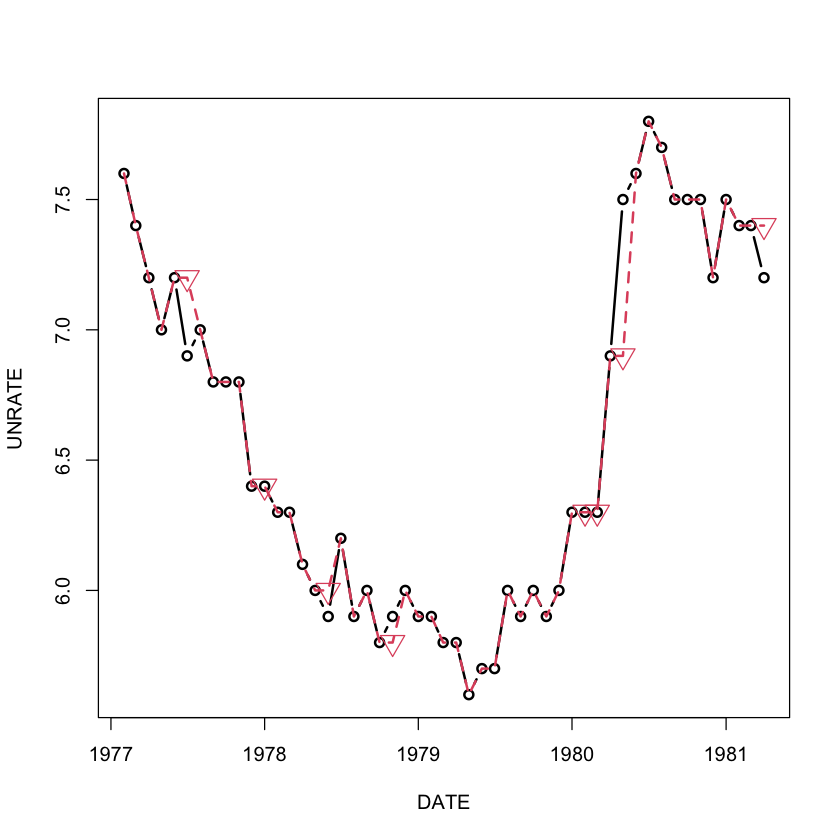

In [7]:
rand.unemp[, impute.ff:=na.locf(UNRATE, na.rm=FALSE)]
bias.unemp[, impute.ff:=na.locf(UNRATE, na.rm=FALSE)]

# Plot a sample graph showing the flat portions
unemp[350:400][plot(DATE, UNRATE, col=1, lwd=2, type='b')]
rand.unemp[350:400][lines(DATE, impute.ff, col=2, lwd=2, lty=2)]
rand.unemp[350:400][rpt==TRUE, points(DATE, impute.ff, col=2, pch=6, cex=2)]

#### Moving average

In [8]:
# Rolling mean without a lookahead
rand.unemp[, impute.rm.nolookahead:=rollapply(c(NA, NA, UNRATE), 3, 
                                             function(x){
                                                 if (!is.na(x[3])) x[3] else mean(x, na.rm=TRUE)
                                                     })]
bias.unemp[, impute.rm.nolookahead:=rollapply(c(NA, NA, UNRATE), 3,
                                             function(x){
                                                 if (!is.na(x[3])) x[3] else mean(x, na.rm=TRUE)
                                             })]

In [9]:
# Rolling mean with a lookahead
rand.unemp[, impute.rm.lookahead:=rollapply(c(NA, UNRATE, NA), 3,
                                           function(x){
                                               if (!is.na(x[2])) x[2] else mean(x, na.rm=TRUE)
                                           })]

<0 x 0 matrix>

<0 x 0 matrix>

<0 x 0 matrix>

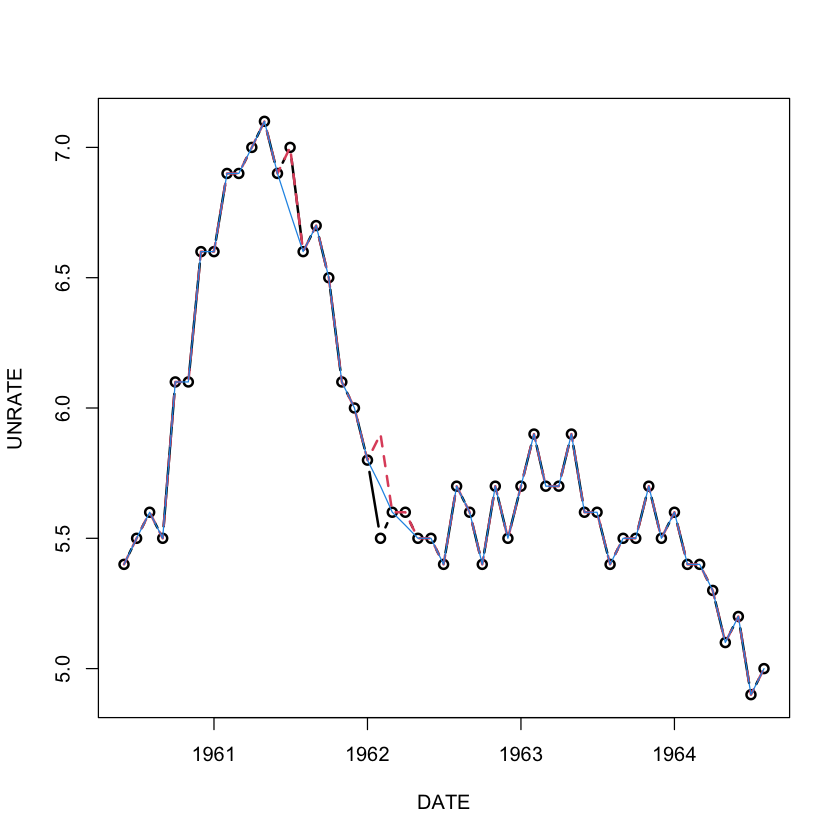

In [10]:
# Plot a sample graph showing imputation without lookahead and with lookahead
unemp[150:200][plot(DATE, UNRATE, col=1, lwd=2, type='b')]
rand.unemp[150:200][lines(DATE, impute.rm.nolookahead, col=2, lwd=2, lty=2)]
rand.unemp[150:200][lines(DATE, impute.rm.lookahead, col=4, pch=6, cex=2)]

#### Interpolation

In [11]:
# Linear interpolation
rand.unemp[, impute.li := na.approx(UNRATE)]
bias.unemp[, impute.li := na.approx(UNRATE)]

# Polynomial interpolation
rand.unemp[, impute.sp:=na.spline(UNRATE)]
bias.unemp[, impute.sp:=na.spline(UNRATE)]

use.idx = 90:120
unemp[use.idx, plot(DATE, UNRATE, col=1, type='b')]
rand.unemp[use.idx, lines(DATE, impute.li, col=2, lwd=2, lty=2)]
rand.unemp[use.idx, lines(DATE, impute.sp, col=3, lwd=2, lty=3)]

ERROR: Error in `[.data.table`(rand.unemp, , `:=`(impute.li, na.approx(UNRATE))): Supplied 843 items to be assigned to 844 items of column 'impute.li'. If you wish to 'recycle' the RHS please use rep() to make this intent clear to readers of your code.


#### Overall comparison

In [14]:
sort(rand.unemp[, lapply(.SD, function(x) mean((x - unemp$RATE)^2, na.rm=TRUE)),
                         .SDcols = c('impute.ff', 'impute.rm.lookahead', 'impute.rm.nolookahead')])

Warning message in xtfrm.data.frame(x):
“impossible d’utiliser xtfrm sur un tableau de données (data frame)”


<0 x 0 matrix>